In [4]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "C:/Users/Admin/.kaggle"


In [6]:
!kaggle datasets download -d datamunge/sign-language-mnist


Dataset URL: https://www.kaggle.com/datasets/datamunge/sign-language-mnist
License(s): CC0-1.0
sign-language-mnist.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
import zipfile

with zipfile.ZipFile("sign-language-mnist.zip", 'r') as zip_ref:
    zip_ref.extractall("sign_mnist")


In [8]:
import pandas as pd

train_df = pd.read_csv("sign_mnist/sign_mnist_train.csv")
test_df = pd.read_csv("sign_mnist/sign_mnist_test.csv")

print("✅ Train shape:", train_df.shape)
print("✅ Test shape:", test_df.shape)
train_df.head()


✅ Train shape: (27455, 785)
✅ Test shape: (7172, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [9]:
import os
import pandas as pd
import numpy as np
from PIL import Image

# Paths
train_csv = "sign_mnist/sign_mnist_train.csv"
test_csv = "sign_mnist/sign_mnist_test.csv"
output_dir = "gesture_dataset"  # Final folder name

# Create output folders
os.makedirs(output_dir, exist_ok=True)


In [10]:
def save_images_from_csv(csv_path, mode):
    df = pd.read_csv(csv_path)
    labels = df['label'].values
    pixels = df.drop('label', axis=1).values

    for i in range(len(labels)):
        label = chr(labels[i] + 65)  # Convert 0 -> 'A', 1 -> 'B', etc.

        label_dir = os.path.join(output_dir, mode, label)
        os.makedirs(label_dir, exist_ok=True)

        img_array = pixels[i].reshape(28, 28).astype(np.uint8)
        img = Image.fromarray(img_array, mode='L')  # Grayscale

        img.save(os.path.join(label_dir, f"{label}_{i}.png"))

    print(f"✅ Saved {len(labels)} images for '{mode}'")


In [11]:
save_images_from_csv(train_csv, "train")
save_images_from_csv(test_csv, "test")


✅ Saved 27455 images for 'train'
✅ Saved 7172 images for 'test'


✅ Loaded 27455 images from 24 classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
Example image shape (flattened): (4096,)
First label: A

📊 Classification Report:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00       209
           B       1.00      1.00      1.00       182
           C       1.00      1.00      1.00       250
           D       1.00      1.00      1.00       255
           E       1.00      1.00      1.00       183
           F       1.00      1.00      1.00       246
           G       1.00      1.00      1.00       213
           H       1.00      1.00      1.00       225
           I       1.00      1.00      1.00       220
           K       1.00      1.00      1.00       227
           L       1.00      1.00      1.00       249
           M       1.00      1.00      1.00       216
           N       1.00      1.00      1.00       236


<Figure size 1000x800 with 0 Axes>

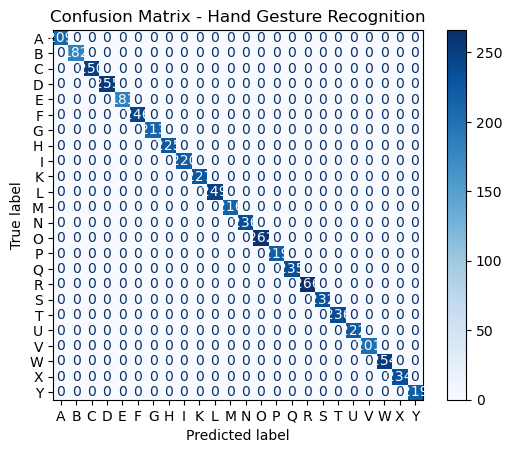

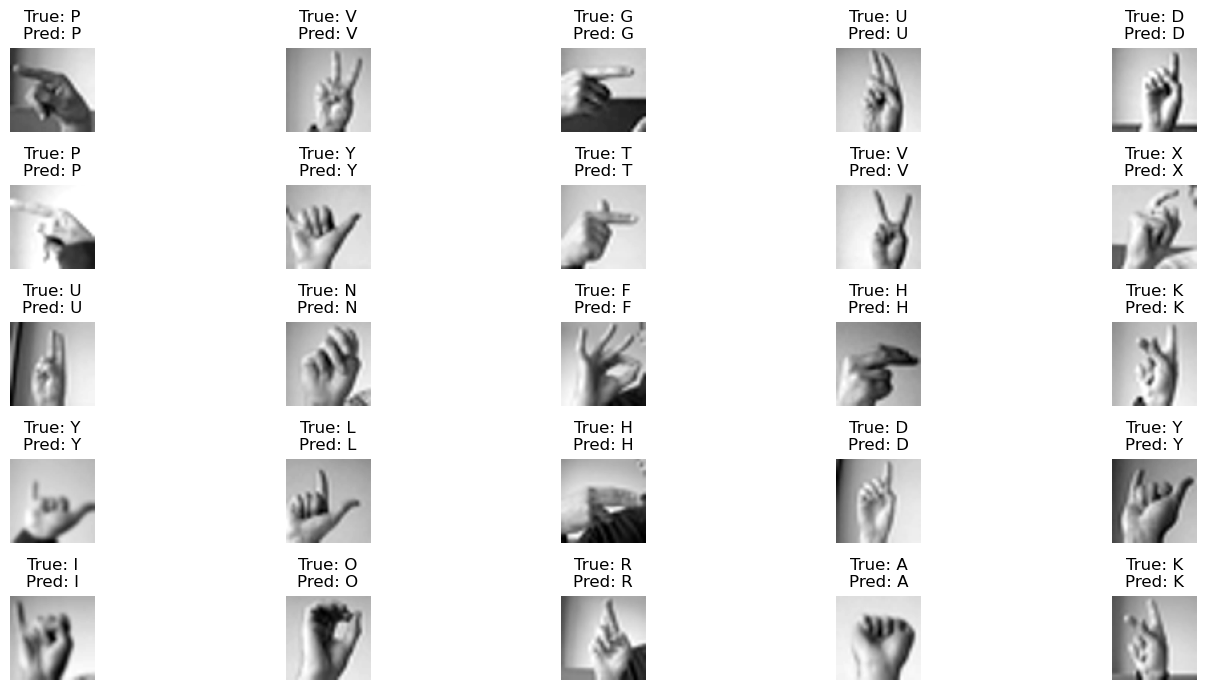

In [20]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# -------------------------
# 1. Load Image Dataset
# -------------------------
def load_images_from_folder(base_path, image_size=(64, 64)):
    X = []
    y = []
    labels = sorted(os.listdir(base_path))  # A-Z

    for label in labels:
        label_folder = os.path.join(base_path, label)
        if not os.path.isdir(label_folder):
            continue
        for img_file in os.listdir(label_folder):
            if img_file.lower().endswith((".jpg", ".jpeg", ".png")):
                img_path = os.path.join(label_folder, img_file)
                try:
                    img = Image.open(img_path).convert("L").resize(image_size)  # Grayscale
                    img_array = np.array(img).flatten() / 255.0
                    X.append(img_array)
                    y.append(label)
                except:
                    print(f"⚠️ Skipped unreadable image: {img_path}")
    return np.array(X), np.array(y)

# -------------------------
# 2. Load & Split Data
# -------------------------
train_path = "gesture_dataset/train"
X, y = load_images_from_folder(train_path, image_size=(64, 64))

print(f"✅ Loaded {len(X)} images from {len(np.unique(y))} classes: {sorted(np.unique(y))}")
print(f"Example image shape (flattened): {X[0].shape}")
print(f"First label: {y[0]}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------
# 3. Train Model
# -------------------------
model = SVC(kernel='linear')
model.fit(X_train, y_train)

# -------------------------
# 4. Predict & Evaluate
# -------------------------
y_pred = model.predict(X_test)

print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))
print("🔍 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# -------------------------
# 5. Save Outputs
# -------------------------
os.makedirs("output", exist_ok=True)

# Save classification report
with open("output/classification_report.txt", "w") as f:
    f.write("Classification Report:\n")
    f.write(classification_report(y_test, y_pred))

# Save confusion matrix plot
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix - Hand Gesture Recognition")
plt.savefig("output/confusion_matrix.png")
plt.show()

# -------------------------
# 6. Display Sample Images with Labels
# -------------------------
def show_images(X_test, y_test, y_pred, num_images=25):
    plt.figure(figsize=(15, 7))
    for i in range(min(num_images, len(X_test))):
        plt.subplot(5, 5, i + 1)
        plt.imshow(X_test[i].reshape(64, 64), cmap='gray')
        plt.title(f"True: {y_test[i]}\nPred: {y_pred[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show 25 test images with predicted labels
show_images(X_test, y_test, y_pred, num_images=25)
